# CODE-15% Dataset EDA

This notebook performs exploratory data analysis on the CODE-15% ECG dataset converted to WFDB format. 
We will validate the output, extract key metadata, explore label distribution, and visualize sample ECG signals.


## Imports and setup

In [55]:
# Import libraries
import os
import wfdb
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pprint, re

In [56]:
# Path to the WFDB files converted from CODE-15%
data_dir = "code15_output/exams_part1"

# Collect all header files (*.hea) in that folder
hea_files = [f for f in os.listdir(data_dir) if f.endswith(".hea")]

# Quick sanity-check
print(f"Found {len(hea_files):,} .hea files")
print("First 5 headers:", hea_files[:5])

# Pick three random records to confirm the label format
for hea in random.sample(hea_files, 3):
    rec_name = hea[:-4]                               # strip ".hea"
    hdr = wfdb.rdheader(os.path.join(data_dir, rec_name))
    
    print(f"\n--- {rec_name}.hea ---")
    # Show the first few comment lines in the header
    for line in hdr.comments[:6]:
        print(line)

Found 19,897 .hea files
First 5 headers: ['100003.hea', '1000049.hea', '1000072.hea', '1000108.hea', '1000151.hea']

--- 3016384.hea ---
Age: 77
Sex: Female
Chagas label: False
Source: CODE-15%

--- 165853.hea ---
Age: 70
Sex: Female
Chagas label: False
Source: CODE-15%

--- 197562.hea ---
Age: 85
Sex: Female
Chagas label: False
Source: CODE-15%


In [57]:
# Collect all record names (without the .hea extension)
record_names = [f[:-4] for f in os.listdir(data_dir) if f.endswith(".hea")]

# Function to extract the Chagas label from comments
def get_chagas_label(comments):
    """
    Return numeric label and the raw header line for inspection.
    """
    for line in comments:
        if 'Chagas label' in line:
            llow = line.lower()
            if 'true' in llow:
                return 1, line.strip()
            if 'false' in llow:
                return 0, line.strip()
    return None, None

# Sample three random records
for rec in random.sample(record_names, 3):
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    label_num, raw_line = get_chagas_label(hdr.comments)
    print(f"{rec} → {raw_line}  → numeric label = {label_num}")

4409636 → Chagas label: False  → numeric label = 0
3208542 → Chagas label: False  → numeric label = 0
531094 → Chagas label: False  → numeric label = 0


In [58]:
# Scan up to 2 000 records to find a 'True' label
found = None
for rec in record_names[:2000]:
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    label_num, raw_line = get_chagas_label(hdr.comments)
    if label_num == 1:
        found = (rec, raw_line, label_num)
        break

if found:
    rec, raw_line, label_num = found
    print(f"{rec} → {raw_line}  → numeric label = {label_num}")
else:
    print("No positive (True) labels in first 2 000 records—data is heavily imbalanced.")


1011368 → Chagas label: True  → numeric label = 1


In [59]:
# Build a DataFrame of record name + numeric Chagas label
sample_size = 5000            # keep small for a quick first run
records = []

for rec in record_names[:sample_size]:
    hdr         = wfdb.rdheader(os.path.join(data_dir, rec))
    label_num, _ = get_chagas_label(hdr.comments)
    records.append({'record': rec, 'label': label_num})

df = pd.DataFrame(records)
print(df.head())
print("\nLabel counts:\n", df['label'].value_counts(dropna=False))

    record  label
0   100003      0
1  1000049      0
2  1000072      0
3  1000108      0
4  1000151      0

Label counts:
 label
0    4914
1      86
Name: count, dtype: int64


### Data preparation functions

In [60]:
def get_chagas_label(comments):
    """Extract Chagas label.
    Args: comments (list[str]) – header comment lines.
    Returns: (int|None, str|None) – numeric label 0/1 and raw line."""
    for line in comments:
        if 'Chagas label' in line:
            low = line.lower()
            if 'true' in low:  return 1, line.strip()
            if 'false' in low: return 0, line.strip()
    return None, None

def parse_age_sex(comments):
    """Extract age and sex.
    Args: comments (list[str]).
    Returns: (int|None, str|None) – age and sex."""
    age = sex = None
    for line in comments:
        if line.lower().startswith('age:'):
            m = re.search(r'\d+', line)
            age = int(m.group()) if m else None
        if line.lower().startswith('sex:'):
            sex = line.split(':')[-1].strip()
    return age, sex

In [61]:
# Test get_chagas_label and parse_age_sex on 10 random records
subset = random.sample(record_names, 10)
for rec in subset:
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    lbl, raw = get_chagas_label(hdr.comments)
    age, sex = parse_age_sex(hdr.comments)
    print(f'{rec}: label={lbl}, age={age}, sex={sex} | {raw}')

881597: label=0, age=27, sex=Female | Chagas label: False
691981: label=0, age=77, sex=Female | Chagas label: False
1324172: label=0, age=43, sex=Female | Chagas label: False
1425036: label=0, age=83, sex=Female | Chagas label: False
1666198: label=0, age=36, sex=Male | Chagas label: False
1399306: label=0, age=59, sex=Female | Chagas label: False
1309179: label=0, age=71, sex=Male | Chagas label: False
1402743: label=0, age=72, sex=Male | Chagas label: False
2800891: label=0, age=26, sex=Male | Chagas label: False
1109079: label=0, age=69, sex=Female | Chagas label: False


In [62]:
# Build DataFrame of record-level metadata and save to CSV
records = []
for rec in record_names:
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    label, _ = get_chagas_label(hdr.comments)
    age, sex  = parse_age_sex(hdr.comments)
    records.append({
        'record': rec,
        'label': label,
        'age': age,
        'sex': sex,
        'fs': hdr.fs,
        'length': hdr.sig_len,
        'path': f'{data_dir}/{rec}',
        'source': 'CODE15'
    })

meta = pd.DataFrame(records)
meta.to_csv('code15_metadata_full.csv', index=False)
print(f'saved {meta.shape[0]} rows to code15_metadata_full.csv')


saved 19897 rows to code15_metadata_full.csv


In [63]:
# Load the saved metadata CSV and show label counts
meta = pd.read_csv('code15_metadata_full.csv')
print(meta['label'].value_counts(dropna=False))

label
0    19480
1      417
Name: count, dtype: int64


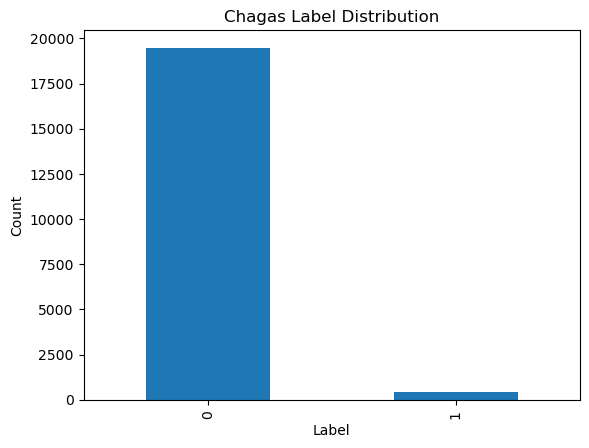

In [64]:
labels = []
for rec in record_names:
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    label, _ = get_chagas_label(hdr.comments)
    if label is not None:
        labels.append(label)

labels_df = pd.Series(labels, name="Chagas_Label")
labels_df.value_counts().plot(kind='bar', title="Chagas Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


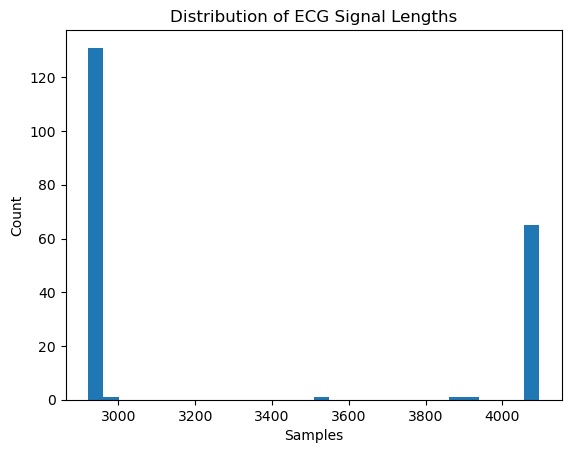

In [65]:
lengths = []
for rec in random.sample(record_names, 200):  # Limit for speed
    try:
        record = wfdb.rdrecord(os.path.join(data_dir, rec), channels=[0])
        lengths.append(len(record.p_signal))
    except:
        continue

plt.hist(lengths, bins=30)
plt.title("Distribution of ECG Signal Lengths")
plt.xlabel("Samples")
plt.ylabel("Count")
plt.show()


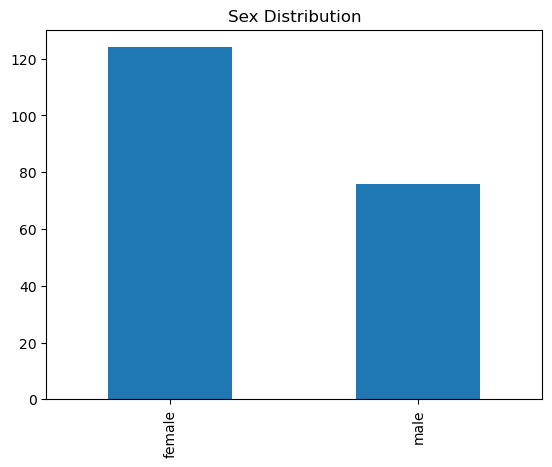

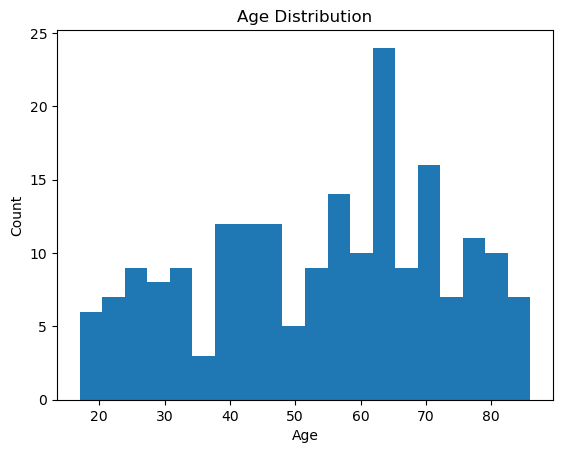

In [66]:
ages, sexes = [], []
for rec in random.sample(record_names, 200):
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    comment_str = " ".join(hdr.comments).lower()
    match_age = re.search(r"age:\s*(\d+)", comment_str)
    match_sex = re.search(r"sex:\s*(\w+)", comment_str)

    if match_age: ages.append(int(match_age.group(1)))
    if match_sex: sexes.append(match_sex.group(1))

pd.Series(sexes).value_counts().plot(kind='bar', title="Sex Distribution")
plt.show()

plt.hist(ages, bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


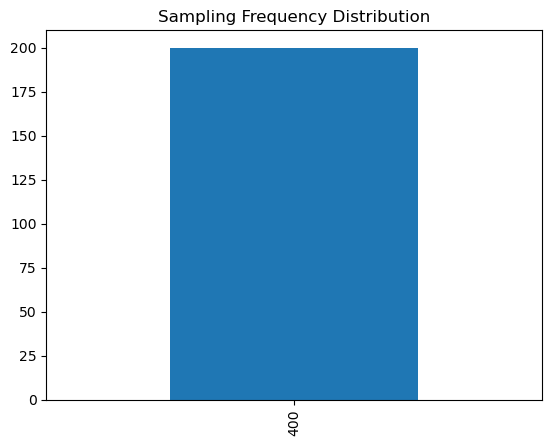

In [67]:
freqs = []
for rec in random.sample(record_names, 200):
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    freqs.append(hdr.fs)

pd.Series(freqs).value_counts().plot(kind='bar', title="Sampling Frequency Distribution")
plt.show()


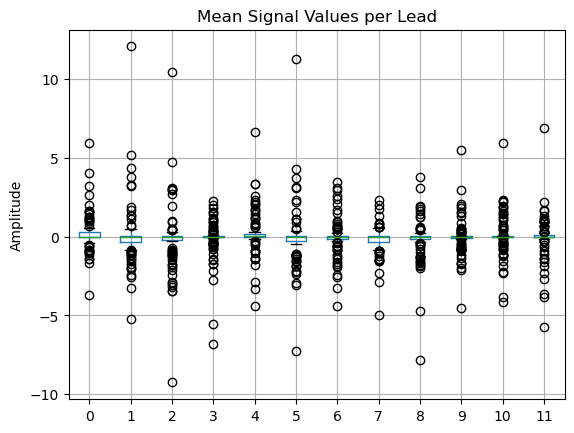

In [68]:
from scipy.stats import zscore

all_means = []
for rec in random.sample(record_names, 100):
    try:
        sig = wfdb.rdrecord(os.path.join(data_dir, rec)).p_signal
        all_means.append(sig.mean(axis=0))  # mean for each lead
    except:
        continue

df_means = pd.DataFrame(all_means)
df_means.boxplot()
plt.title("Mean Signal Values per Lead")
plt.ylabel("Amplitude")
plt.show()
